In [34]:
#%run ../Exploring_data/Exploratory_analysis.ipynb

# Number of days for the prediction

In the next line we are going to choose the number of days we want to predict. For this project we have chosen 7 days, but it can be changed for investigating:

In [35]:
days = 28

## XGBoost with shuffled data:

For this model, we are considering a regressor model where all the data is picked up randomly. 

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split

# After importing the modules, we are defining our functions:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [37]:
# We read the data:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')

It is important to considerate the time that we want to predict. If we want to know the price for 1 week, we will need to shift the target column X days so, with the information we have today, we can predict the value for the electricity in X days:

In [38]:
# We multiply the number of days that we want to predict by 24 and then we drop the rows without target:
df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']=df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)'].shift(-24*days)
df.dropna(axis=0,how='any',inplace=True)

Then we select the columns that we will use:

In [39]:
model_columns = ['Demanda_programada_P48_total', 
                  'Demanda_programada_P48_Correccion_eolica',
                  'Demanda_programada_P48_Correccion_solar',
                  'Precio_mercado_SPOT_Diario',
                  'Precio_mercado_SPOT_Intradiario_Sesion_1',
                  'Precio_mercado_SPOT_Intradiario_Sesion_2',
                  'Precio_mercado_SPOT_Intradiario_Sesion_3',
                  'Precio_mercado_SPOT_Intradiario_Sesion_4',
                  'Precio_mercado_SPOT_Intradiario_Sesion_5',
                  'Precio_mercado_SPOT_Intradiario_Sesion_6',
                  'Precio_mercado_SPOT_Intradiario_Sesion_7',
                  'Generacion_programada_P48_Biogas',
                  'Generacion_programada_P48_Biomasa',
                  'Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo',
                 'Generacion_programada_P48_Derivados_del_petroleo_o_carbon',
                 'Generacion_programada_P48_Energia_residual',
                 'Generacion_programada_P48_Enlace_Baleares',
                 'Generacion_programada_P48_Eolica_terrestre',
                  'Generacion_programada_P48_Gas_Natural',
                 'Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hidraulica_UGH',
                 'Generacion_programada_P48_Hidraulica_no_UGH',
                 'Generacion_programada_P48_Hulla_antracita',
                 'Generacion_programada_P48_Hulla_sub-bituminosa',
                 'Generacion_programada_P48_Nuclear',
                 'Generacion_programada_P48_Oceano_y_geotermica',
                 'Generacion_programada_P48_Residuos_domesticos_y_similares',
                 'Generacion_programada_P48_Residuos_varios',
                 'Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica',
                 'Generacion_programada_P48_Subproductos_mineria',
                  'Generacion_programada_P48_Turbinacion_bombeo',
                 'Consumer_price_index', 
                 'Time_required_to_get_electricity_(days)',
                 'Inflation,consumer_prices_(annual_%)',
                 'Employment_in_industry_(%_of_total_employment)', 
                 'PIB_Trimestral', 
                 'Var_Trim_PIB_(%)', 
                 'Var_anual_PIB_Trim_(%)',
                 'IBEX35',
                 'Red_Electrica',
                 'Temperature',
                 #'Weekday_Monday','Weekday_Tuesday', 'Weekday_Wednesday','Weekday_Thursday',
                 #'Weekday_Friday', 'Weekday_Saturday', 
                 'sin_weekday','cos_weekday',
                 'holidays', 
                 #'Hour_0', 'Hour_1', 'Hour_2',
                 #'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9',
                 #'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
                 #'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
                 #'Hour_22',
                 'sin_hour','cos_hour','sin_month','cos_month',
                 #'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
                 #'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
                 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8',
                 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15',
                 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22',
                 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29',
                 'Day_30']

After selecting the columns, we have to split the data into train, validation for the model and test.

In [40]:
X = df.loc[:,model_columns]
y = df.loc[:,'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']
# We split train and test with a ratio of 0.8-0.2
X_train_aux, X_test, y_train_aux, y_test = train_test_split(X.iloc[:df.shape[0]-24*days,], y.iloc[:df.shape[0]-24*days,], train_size=0.8,test_size=0.2, random_state=101)
# From the train, we take out a 0.2 portion of the dataframe for validating the model:
X_train, X_validation, y_train, y_validation = train_test_split(X_train_aux, y_train_aux, train_size=0.8,test_size=0.2, random_state=101)
# For our prediction:
X_test_pred = X.iloc[df.shape[0]-24*days:,]
y_test_pred = y.iloc[df.shape[0]-24*days:,]

Then, we look for the best model. In order to achieve that, we will use GridSearchCV, which allow us to do a Cross Validation and fit for the best model with the parameters we try on it:

In [41]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 20, n_estimators = 200, early_stopping_rounds = 15)

parameters = {'colsample_bytree':[0.4,0.3],'learning_rate': [0.1,0.15,0.2],
                'max_depth': [5,7,9]}

xgb_mod = GridSearchCV(xg_reg,cv=5,verbose=1,param_grid=parameters,
                       scoring='neg_mean_squared_error',n_jobs=-1, error_score='raise')

In [42]:
%%time
xgb_mod.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  6.8min finished


CPU times: user 51.3 s, sys: 1.61 s, total: 52.9 s
Wall time: 6min 52s


GridSearchCV(cv=5, error_score='raise',
             estimator=XGBRegressor(alpha=20, base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.3,
                                    early_stopping_rounds=15, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=None,
                                    missing=nan, m...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid='warn', n_job

In [43]:
print('El RMSE para nuestro mejor modelo es: ',np.sqrt(abs(xgb_mod.best_score_)))

El RMSE para nuestro mejor modelo es:  5.523762273933596


After that, we fit our best model into our data:

In [44]:
eval_set = [(X_train, y_train), (X_validation, y_validation)]

xgb_mod.best_estimator_.fit(X_train,y_train,eval_metric=["rmse", "mae"], eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:81.06060	validation_0-mae:73.60479	validation_1-rmse:80.27451	validation_1-mae:72.82382
[1]	validation_0-rmse:65.18445	validation_0-mae:58.93666	validation_1-rmse:64.57515	validation_1-mae:58.33096
[2]	validation_0-rmse:52.81621	validation_0-mae:47.26669	validation_1-rmse:52.33473	validation_1-mae:46.78013
[3]	validation_0-rmse:43.30199	validation_0-mae:38.04493	validation_1-rmse:42.93470	validation_1-mae:37.62660
[4]	validation_0-rmse:35.75450	validation_0-mae:30.79224	validation_1-rmse:35.49948	validation_1-mae:30.46816
[5]	validation_0-rmse:29.17462	validation_0-mae:24.95995	validation_1-rmse:29.02199	validation_1-mae:24.75366
[6]	validation_0-rmse:24.03911	validation_0-mae:20.36064	validation_1-rmse:23.97674	validation_1-mae:20.27183
[7]	validation_0-rmse:20.05889	validation_0-mae:16.79339	validation_1-rmse:20.08336	validation_1-mae:16.80198
[8]	validation_0-rmse:17.25658	validation_0-mae:14.20445	validation_1-rmse:17.35688	validation_1-mae:14.27831
[9]	valida

[77]	validation_0-rmse:4.77524	validation_0-mae:3.66116	validation_1-rmse:6.14068	validation_1-mae:4.65725
[78]	validation_0-rmse:4.75321	validation_0-mae:3.64490	validation_1-rmse:6.12782	validation_1-mae:4.64791
[79]	validation_0-rmse:4.72933	validation_0-mae:3.62463	validation_1-rmse:6.11313	validation_1-mae:4.63553
[80]	validation_0-rmse:4.71627	validation_0-mae:3.61372	validation_1-rmse:6.10373	validation_1-mae:4.62799
[81]	validation_0-rmse:4.69748	validation_0-mae:3.59850	validation_1-rmse:6.08852	validation_1-mae:4.61663
[82]	validation_0-rmse:4.67776	validation_0-mae:3.58339	validation_1-rmse:6.07726	validation_1-mae:4.60679
[83]	validation_0-rmse:4.65292	validation_0-mae:3.56493	validation_1-rmse:6.06458	validation_1-mae:4.59763
[84]	validation_0-rmse:4.61973	validation_0-mae:3.54063	validation_1-rmse:6.03908	validation_1-mae:4.57830
[85]	validation_0-rmse:4.60613	validation_0-mae:3.52933	validation_1-rmse:6.03231	validation_1-mae:4.57179
[86]	validation_0-rmse:4.58095	valida

[154]	validation_0-rmse:3.52842	validation_0-mae:2.68308	validation_1-rmse:5.38882	validation_1-mae:4.07034
[155]	validation_0-rmse:3.51931	validation_0-mae:2.67617	validation_1-rmse:5.38447	validation_1-mae:4.06719
[156]	validation_0-rmse:3.50614	validation_0-mae:2.66645	validation_1-rmse:5.37716	validation_1-mae:4.06171
[157]	validation_0-rmse:3.50326	validation_0-mae:2.66410	validation_1-rmse:5.37521	validation_1-mae:4.06026
[158]	validation_0-rmse:3.49678	validation_0-mae:2.65853	validation_1-rmse:5.37411	validation_1-mae:4.05875
[159]	validation_0-rmse:3.49463	validation_0-mae:2.65665	validation_1-rmse:5.37254	validation_1-mae:4.05757
[160]	validation_0-rmse:3.48325	validation_0-mae:2.64885	validation_1-rmse:5.36762	validation_1-mae:4.05291
[161]	validation_0-rmse:3.47234	validation_0-mae:2.63987	validation_1-rmse:5.36094	validation_1-mae:4.04736
[162]	validation_0-rmse:3.46122	validation_0-mae:2.63113	validation_1-rmse:5.35464	validation_1-mae:4.04232
[163]	validation_0-rmse:3.44

XGBRegressor(alpha=20, base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, early_stopping_rounds=15,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.2, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=200, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=20, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

We can have a look into the most important features in the model:

In [45]:
# We print a dataframe with the importance of each feature:
pd.DataFrame(xgb_mod.best_estimator_.feature_importances_.reshape(1, -1), columns=X.columns)

,Demanda_programada_P48_total,Demanda_programada_P48_Correccion_eolica,Demanda_programada_P48_Correccion_solar,Precio_mercado_SPOT_Diario,Precio_mercado_SPOT_Intradiario_Sesion_1,Precio_mercado_SPOT_Intradiario_Sesion_2,Precio_mercado_SPOT_Intradiario_Sesion_3,Precio_mercado_SPOT_Intradiario_Sesion_4,Precio_mercado_SPOT_Intradiario_Sesion_5,Precio_mercado_SPOT_Intradiario_Sesion_6,...,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30
0,0.004014,0.000218,0.004096,0.016458,0.008648,0.001711,0.000879,0.04364,0.136708,0.276288,...,0.000569,0.000672,0.000693,0.000765,0.000461,0.000426,0.000375,0.000641,0.000834,0.000345


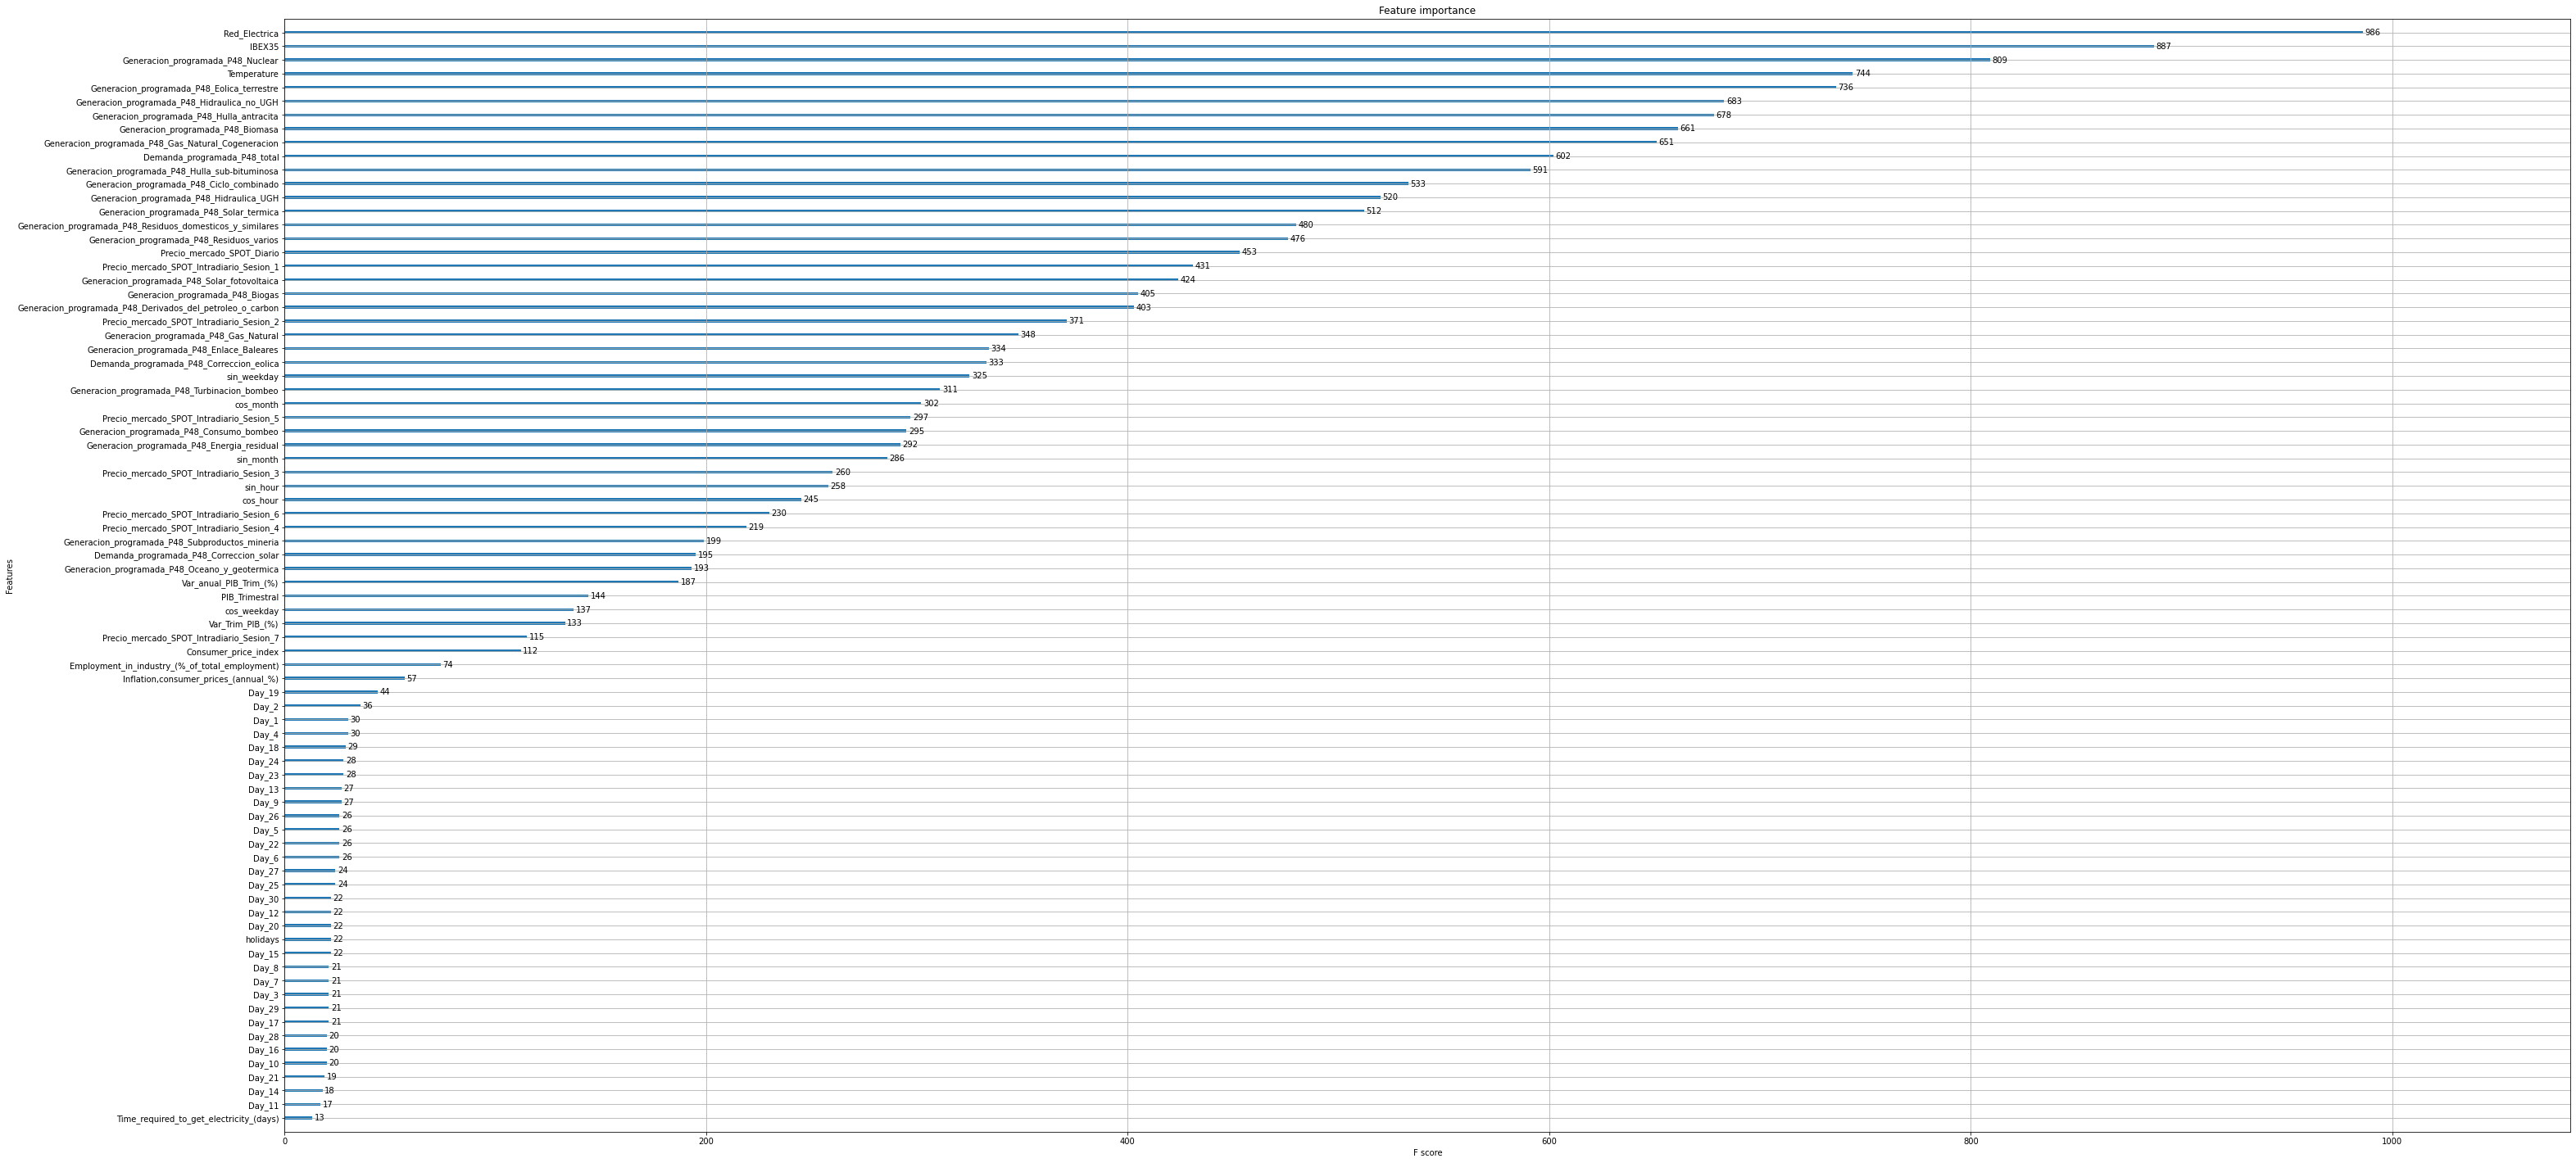

In [46]:
xgb.plot_importance(xgb_mod.best_estimator_)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

Then we calculate our prediction and check the metrics:

In [47]:
y_pred = xgb_mod.best_estimator_.predict(X_test) 
print('Se obtiene un RMSE de ',np.sqrt(mean_squared_error(y_test, y_pred)),', un R2 de ',r2_score(y_test, y_pred),' y un MAPE de',mean_absolute_percentage_error(y_test, y_pred))

Se obtiene un RMSE de  5.258026923040707 , un R2 de  0.9815674130875949  y un MAPE de 5.467812321123662


Last, we plot the results:

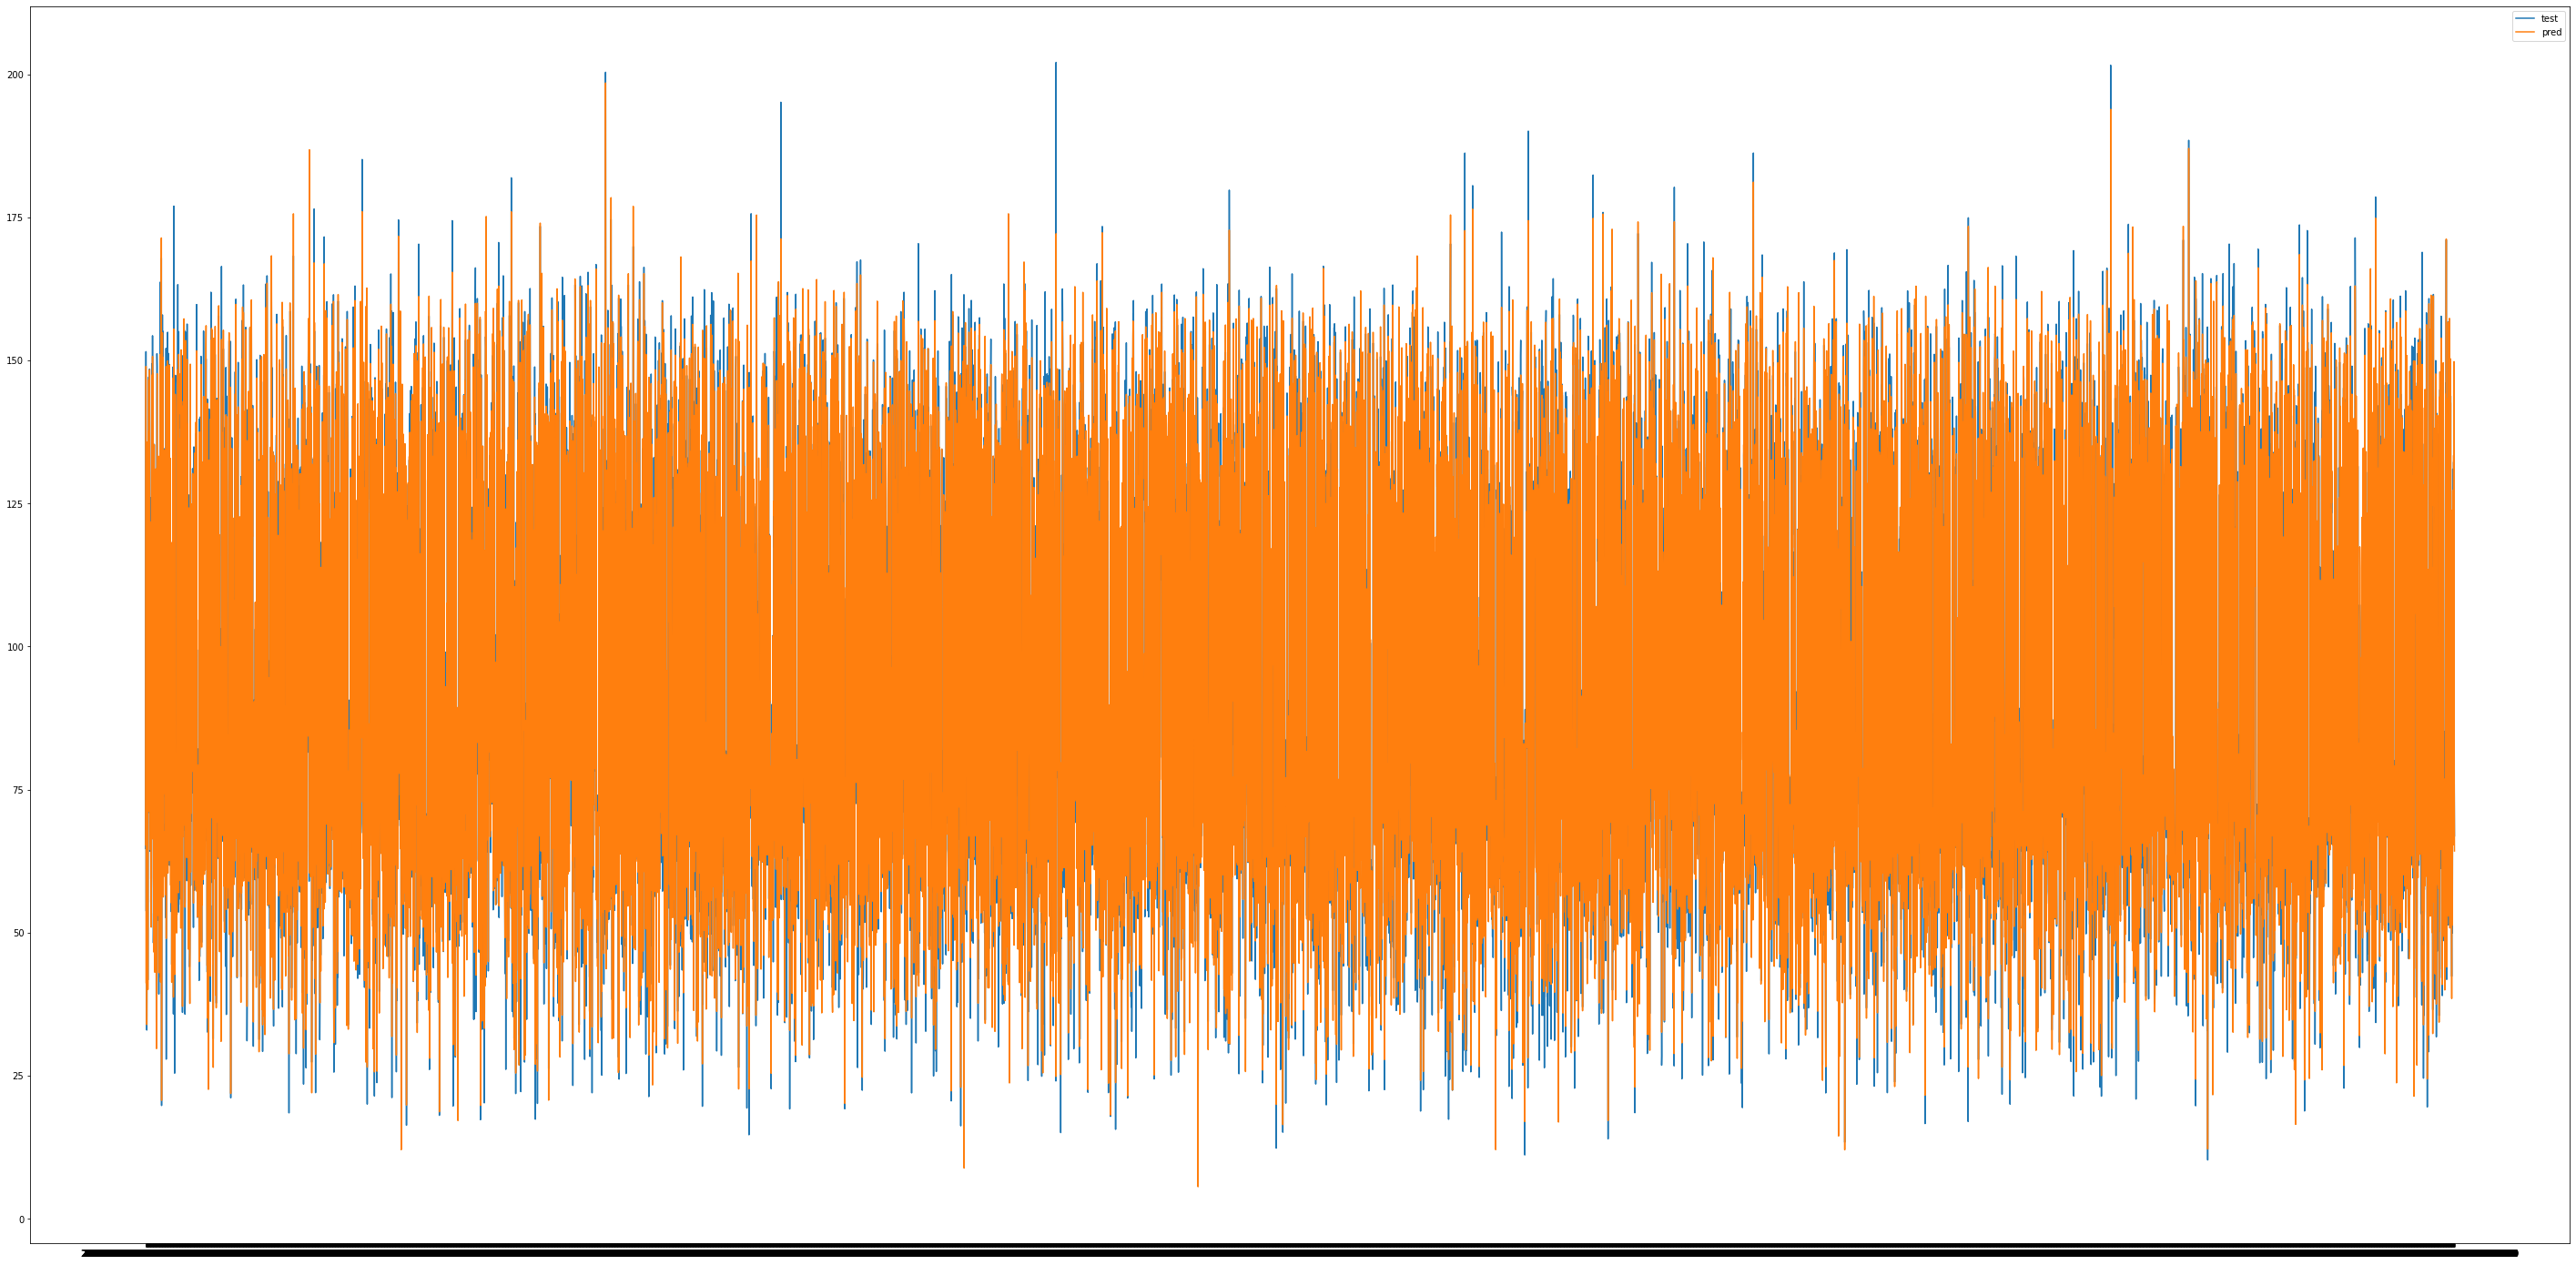

In [48]:
plt.rcParams['figure.figsize'] = [50, 25]
plt.plot(y_test, label='test')
plt.plot(y_pred, label='pred')
plt.legend()
plt.show()

Checking the forecasting for the last days:

Se obtiene un RMSE de  5.775169854352853 , un R2 de  0.9713156199403902  y un MAPE de 7.624060364902586


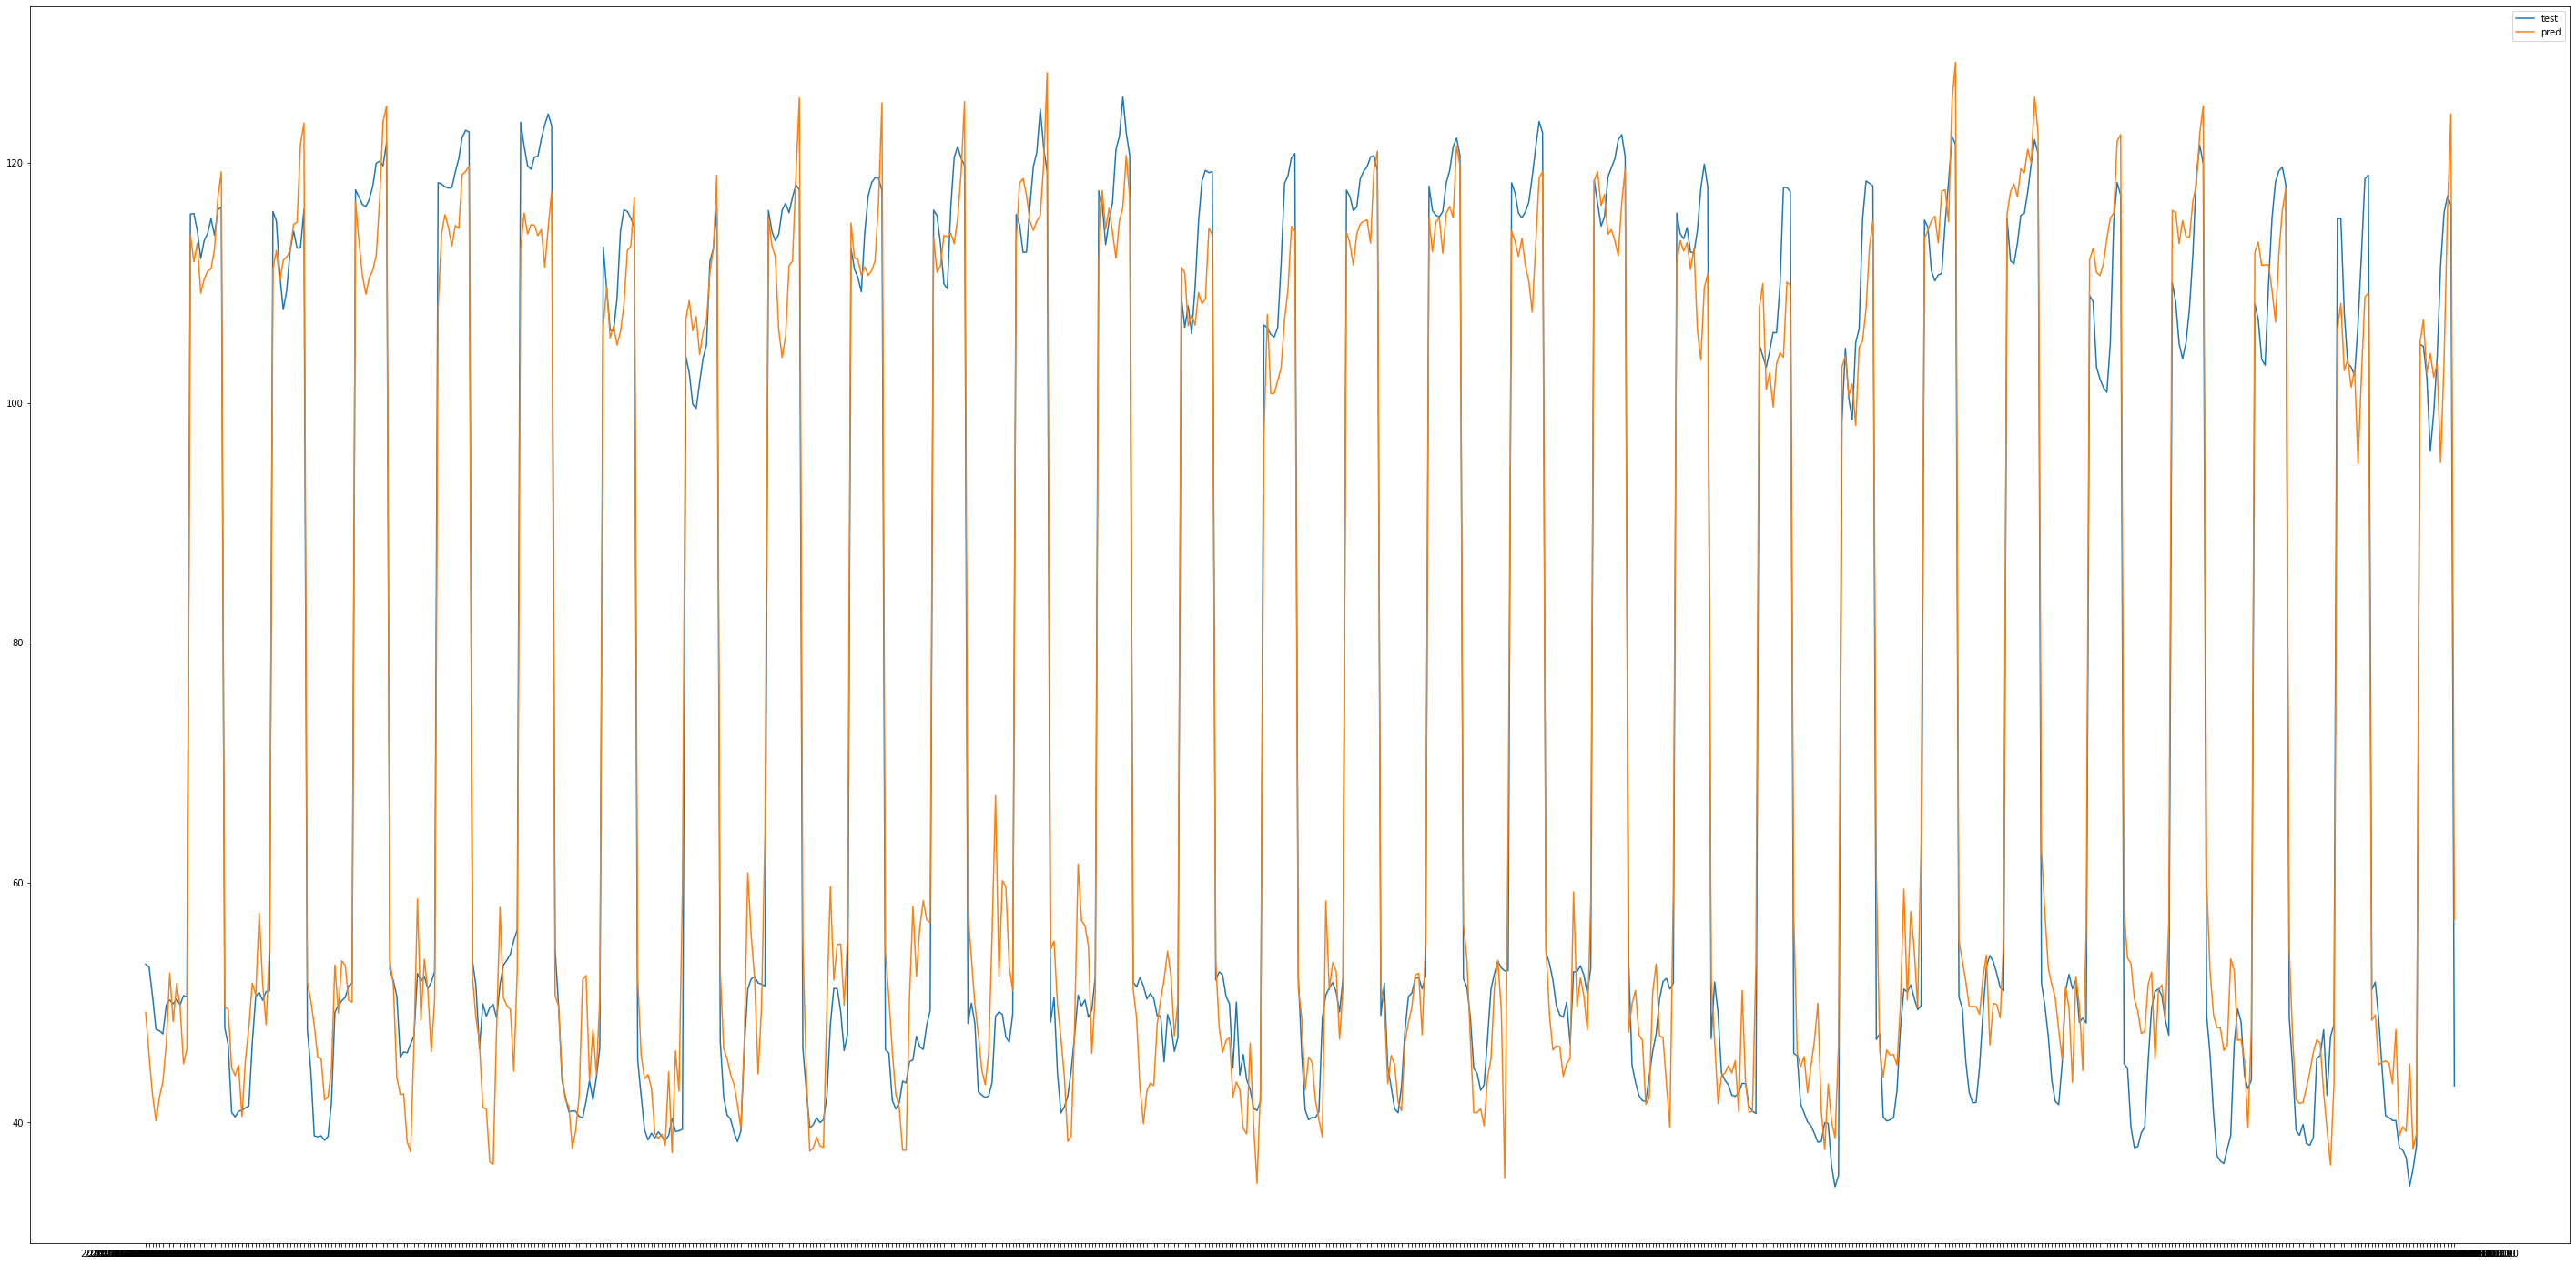

In [49]:
y_pred_test = xgb_mod.best_estimator_.predict(X_test_pred) 

print('Se obtiene un RMSE de ',np.sqrt(mean_squared_error(y_test_pred, y_pred_test)),', un R2 de ',r2_score(y_test_pred, y_pred_test),' y un MAPE de',mean_absolute_percentage_error(y_test_pred, y_pred_test))

plt.rcParams['figure.figsize'] = [50, 25]
plt.plot(y_test_pred, label='test')
plt.plot(y_pred_test, label='pred')
plt.legend()
plt.show()

In [50]:
pd.DataFrame({'y_test':y_test, 'y_pred':y_pred},index = y_test.index).to_csv('./../Visualization/Xgboost.csv')

## XGBoost with sorted data:

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split

# After importing the modules, we are defining our functions:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [52]:
# We read the data:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')

It is important to considerate the time that we want to predict. If we want to know the price for 1 week, we will need to shift the target column X days so, with the information we have today, we can predict the value for the electricity in X days:

In [53]:
# We multiply the number of days that we want to predict by 24 and then we drop the rows without target:
df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']=df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)'].shift(-24*days)
df.dropna(axis=0,how='any',inplace=True)

Then we select the columns that we will use:

In [54]:
model_columns = ['Demanda_programada_P48_total', 
                 'Demanda_programada_P48_Correccion_eolica',
                 'Demanda_programada_P48_Correccion_solar',
                 'Precio_mercado_SPOT_Diario',
                 'Precio_mercado_SPOT_Intradiario_Sesion_1',
                 'Precio_mercado_SPOT_Intradiario_Sesion_2',
                 'Precio_mercado_SPOT_Intradiario_Sesion_3',
                 'Precio_mercado_SPOT_Intradiario_Sesion_4',
                 'Precio_mercado_SPOT_Intradiario_Sesion_5',
                 'Precio_mercado_SPOT_Intradiario_Sesion_6',
                 'Precio_mercado_SPOT_Intradiario_Sesion_7',
                 'Generacion_programada_P48_Biogas',
                 'Generacion_programada_P48_Biomasa',
                 'Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo',
                 'Generacion_programada_P48_Derivados_del_petroleo_o_carbon',
                 'Generacion_programada_P48_Energia_residual',
                 'Generacion_programada_P48_Enlace_Baleares',
                 'Generacion_programada_P48_Eolica_terrestre',
                 'Generacion_programada_P48_Gas_Natural',
                 'Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hidraulica_UGH',
                 'Generacion_programada_P48_Hidraulica_no_UGH',
                 'Generacion_programada_P48_Hulla_antracita',
                 'Generacion_programada_P48_Hulla_sub-bituminosa',
                 'Generacion_programada_P48_Nuclear',
                 'Generacion_programada_P48_Oceano_y_geotermica',
                 'Generacion_programada_P48_Residuos_domesticos_y_similares',
                 'Generacion_programada_P48_Residuos_varios',
                 'Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica',
                 'Generacion_programada_P48_Subproductos_mineria',
                 'Generacion_programada_P48_Turbinacion_bombeo',
                 #'Consumer_price_index', 
                 #'Time_required_to_get_electricity_(days)',
                 #'Inflation,consumer_prices_(annual_%)',
                 #'Employment_in_industry_(%_of_total_employment)', 
                 #'PIB_Trimestral', 
                 #'Var_Trim_PIB_(%)', 
                 #'Var_anual_PIB_Trim_(%)',
                 #'IBEX35',
                 #'Red_Electrica',
                 'Temperature',
                 #'Weekday_Monday','Weekday_Tuesday', 'Weekday_Wednesday','Weekday_Thursday',
                 #'Weekday_Friday', 'Weekday_Saturday', 
                 'sin_weekday','cos_weekday',
                 'holidays', 
                 #'Hour_0', 'Hour_1', 'Hour_2',
                 #'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9',
                 #'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
                 #'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
                 #'Hour_22',
                 'sin_hour','cos_hour','sin_month','cos_month',
                 #'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
                 #'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
                 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8',
                 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15',
                 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22',
                 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29',
                 'Day_30']

standarized_columns = ['Demanda_programada_P48_total', 
                 'Demanda_programada_P48_Correccion_eolica',
                 'Demanda_programada_P48_Correccion_solar',
                 'Precio_mercado_SPOT_Diario',
                 'Precio_mercado_SPOT_Intradiario_Sesion_1',
                 'Precio_mercado_SPOT_Intradiario_Sesion_2',
                 'Precio_mercado_SPOT_Intradiario_Sesion_3',
                 'Precio_mercado_SPOT_Intradiario_Sesion_4',
                 'Precio_mercado_SPOT_Intradiario_Sesion_5',
                 'Precio_mercado_SPOT_Intradiario_Sesion_6',
                 'Precio_mercado_SPOT_Intradiario_Sesion_7',
                 'Generacion_programada_P48_Biogas',
                 'Generacion_programada_P48_Biomasa',
                 'Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo',
                 'Generacion_programada_P48_Derivados_del_petroleo_o_carbon',
                 'Generacion_programada_P48_Energia_residual',
                 'Generacion_programada_P48_Enlace_Baleares',
                 'Generacion_programada_P48_Eolica_terrestre',
                 'Generacion_programada_P48_Gas_Natural',
                 'Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hidraulica_UGH',
                 'Generacion_programada_P48_Hidraulica_no_UGH',
                 'Generacion_programada_P48_Hulla_antracita',
                 'Generacion_programada_P48_Hulla_sub-bituminosa',
                 'Generacion_programada_P48_Nuclear',
                 'Generacion_programada_P48_Oceano_y_geotermica',
                 'Generacion_programada_P48_Residuos_domesticos_y_similares',
                 'Generacion_programada_P48_Residuos_varios',
                 'Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica',
                 'Generacion_programada_P48_Subproductos_mineria',
                 'Generacion_programada_P48_Turbinacion_bombeo',
                 #'Consumer_price_index', 
                 #'Time_required_to_get_electricity_(days)',
                 #'Inflation,consumer_prices_(annual_%)',
                 #'Employment_in_industry_(%_of_total_employment)', 
                 #'PIB_Trimestral', 
                 #'Var_Trim_PIB_(%)', 
                 #'Var_anual_PIB_Trim_(%)',
                 #'IBEX35',
                 #'Red_Electrica',
                 'Temperature']

After selecting the columns, we have to split the data into train, validation for the model and test.

In [55]:
X = df.loc[:,model_columns]
y = df.loc[:,'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X[standarized_columns]) 

X[standarized_columns] = scaled_data

y_train = df.loc[:'2018-06-01 00:00:00+00:00',]
X_train = df.loc[:'2018-06-01 00:00:00+00:00',]
y_validation = df.loc['2018-06-01 00:00:00+00:00':'2019-06-01 00:00:00+00:00',]
X_validation = df.loc['2018-06-01 00:00:00+00:00':'2019-06-01 00:00:00+00:00',]
y_test = df.loc['2019-06-01 00:00:00+00:00':,]
X_test = df.loc['2019-06-01 00:00:00+00:00':,]

In [56]:
X = df.loc[:,model_columns]
y = df.loc[:,'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X[standarized_columns]) 

X[standarized_columns] = scaled_data

y_train = y.iloc[:y.shape[0]-days*24,]
X_train = X.iloc[:y.shape[0]-days*24,]
y_test = y.iloc[y.shape[0]-days*24:,]
X_test = X.iloc[y.shape[0]-days*24:,]

Then, we look for the best model. In order to achieve that, we will use GridSearchCV, which allow us to do a Cross Validation and fit for the best model with the parameters we try on it:

In [57]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 20, n_estimators = 200, early_stopping_rounds = 15)

parameters = {'colsample_bytree':[0.4,0.3],'learning_rate': [0.1,0.15,0.2],
                'max_depth': [5,7,9]}

xgb_mod = GridSearchCV(xg_reg,cv=5,verbose=1,param_grid=parameters,
                       scoring='neg_mean_squared_error',n_jobs=-1, error_score='raise')

In [58]:
%%time
xgb_mod.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/joeldela/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  9.3min finished


CPU times: user 51.6 s, sys: 2.27 s, total: 53.9 s
Wall time: 9min 25s


GridSearchCV(cv=5, error_score='raise',
             estimator=XGBRegressor(alpha=20, base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.3,
                                    early_stopping_rounds=15, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=None,
                                    missing=nan, m...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid='warn', n_job

In [59]:
print('El RMSE para nuestro mejor modelo es: ',np.sqrt(abs(xgb_mod.best_score_)))

El RMSE para nuestro mejor modelo es:  15.64604334978914


After that, we fit our best model into our data:

In [60]:
eval_set = [(X_train, y_train), (X_test, y_test)]

xgb_mod.best_estimator_.fit(X_train,y_train,eval_metric=["rmse", "mae"], eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:85.77100	validation_0-mae:77.93923	validation_1-rmse:67.06622	validation_1-mae:60.02551
[1]	validation_0-rmse:73.75571	validation_0-mae:66.27255	validation_1-rmse:56.49754	validation_1-mae:49.71392
[2]	validation_0-rmse:63.33747	validation_0-mae:56.41238	validation_1-rmse:46.79673	validation_1-mae:39.77363
[3]	validation_0-rmse:54.82947	validation_0-mae:48.13485	validation_1-rmse:39.97272	validation_1-mae:32.78854
[4]	validation_0-rmse:47.13063	validation_0-mae:41.11752	validation_1-rmse:33.53031	validation_1-mae:27.28038
[5]	validation_0-rmse:41.06492	validation_0-mae:35.29253	validation_1-rmse:28.35743	validation_1-mae:22.98219
[6]	validation_0-rmse:36.12944	validation_0-mae:30.60010	validation_1-rmse:24.56732	validation_1-mae:20.34396
[7]	validation_0-rmse:31.29927	validation_0-mae:26.39906	validation_1-rmse:20.62759	validation_1-mae:17.36822
[8]	validation_0-rmse:27.39548	validation_0-mae:22.96290	validation_1-rmse:17.40338	validation_1-mae:14.93495
[9]	valida

[76]	validation_0-rmse:7.50564	validation_0-mae:5.72069	validation_1-rmse:7.16677	validation_1-mae:5.42328
[77]	validation_0-rmse:7.48784	validation_0-mae:5.70867	validation_1-rmse:7.16831	validation_1-mae:5.42466
[78]	validation_0-rmse:7.46905	validation_0-mae:5.69443	validation_1-rmse:7.17433	validation_1-mae:5.42797
[79]	validation_0-rmse:7.44012	validation_0-mae:5.67178	validation_1-rmse:7.17709	validation_1-mae:5.43461
[80]	validation_0-rmse:7.43121	validation_0-mae:5.66608	validation_1-rmse:7.18137	validation_1-mae:5.43845
[81]	validation_0-rmse:7.41823	validation_0-mae:5.65496	validation_1-rmse:7.15844	validation_1-mae:5.40554
[82]	validation_0-rmse:7.40325	validation_0-mae:5.64567	validation_1-rmse:7.17543	validation_1-mae:5.42190
[83]	validation_0-rmse:7.37613	validation_0-mae:5.62437	validation_1-rmse:7.10470	validation_1-mae:5.37891
[84]	validation_0-rmse:7.34941	validation_0-mae:5.60696	validation_1-rmse:7.11547	validation_1-mae:5.39007
[85]	validation_0-rmse:7.34076	valida

[153]	validation_0-rmse:6.40143	validation_0-mae:4.89026	validation_1-rmse:6.63284	validation_1-mae:5.12144
[154]	validation_0-rmse:6.39406	validation_0-mae:4.88440	validation_1-rmse:6.62735	validation_1-mae:5.11746
[155]	validation_0-rmse:6.38630	validation_0-mae:4.87888	validation_1-rmse:6.61413	validation_1-mae:5.10865
[156]	validation_0-rmse:6.38394	validation_0-mae:4.87634	validation_1-rmse:6.61852	validation_1-mae:5.11322
[157]	validation_0-rmse:6.37719	validation_0-mae:4.87038	validation_1-rmse:6.61870	validation_1-mae:5.11479
[158]	validation_0-rmse:6.36712	validation_0-mae:4.86284	validation_1-rmse:6.60980	validation_1-mae:5.10815
[159]	validation_0-rmse:6.35830	validation_0-mae:4.85521	validation_1-rmse:6.61161	validation_1-mae:5.11192
[160]	validation_0-rmse:6.35129	validation_0-mae:4.84918	validation_1-rmse:6.61360	validation_1-mae:5.11325
[161]	validation_0-rmse:6.34593	validation_0-mae:4.84448	validation_1-rmse:6.61050	validation_1-mae:5.10975
[162]	validation_0-rmse:6.33

XGBRegressor(alpha=20, base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, early_stopping_rounds=15,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.15, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=200, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=20, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

We can have a look into the most important features in the model:

In [61]:
# We print a dataframe with the importance of each feature:
pd.DataFrame(xgb_mod.best_estimator_.feature_importances_.reshape(1, -1), columns=X.columns)

,Demanda_programada_P48_total,Demanda_programada_P48_Correccion_eolica,Demanda_programada_P48_Correccion_solar,Precio_mercado_SPOT_Diario,Precio_mercado_SPOT_Intradiario_Sesion_1,Precio_mercado_SPOT_Intradiario_Sesion_2,Precio_mercado_SPOT_Intradiario_Sesion_3,Precio_mercado_SPOT_Intradiario_Sesion_4,Precio_mercado_SPOT_Intradiario_Sesion_5,Precio_mercado_SPOT_Intradiario_Sesion_6,...,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30
0,0.024136,0.000232,0.024189,0.021213,0.016052,0.010952,0.004702,0.026308,0.189578,0.228381,...,0.000763,0.000469,0.000749,0.000574,0.000532,0.000311,0.00033,0.000795,0.00048,0.000765


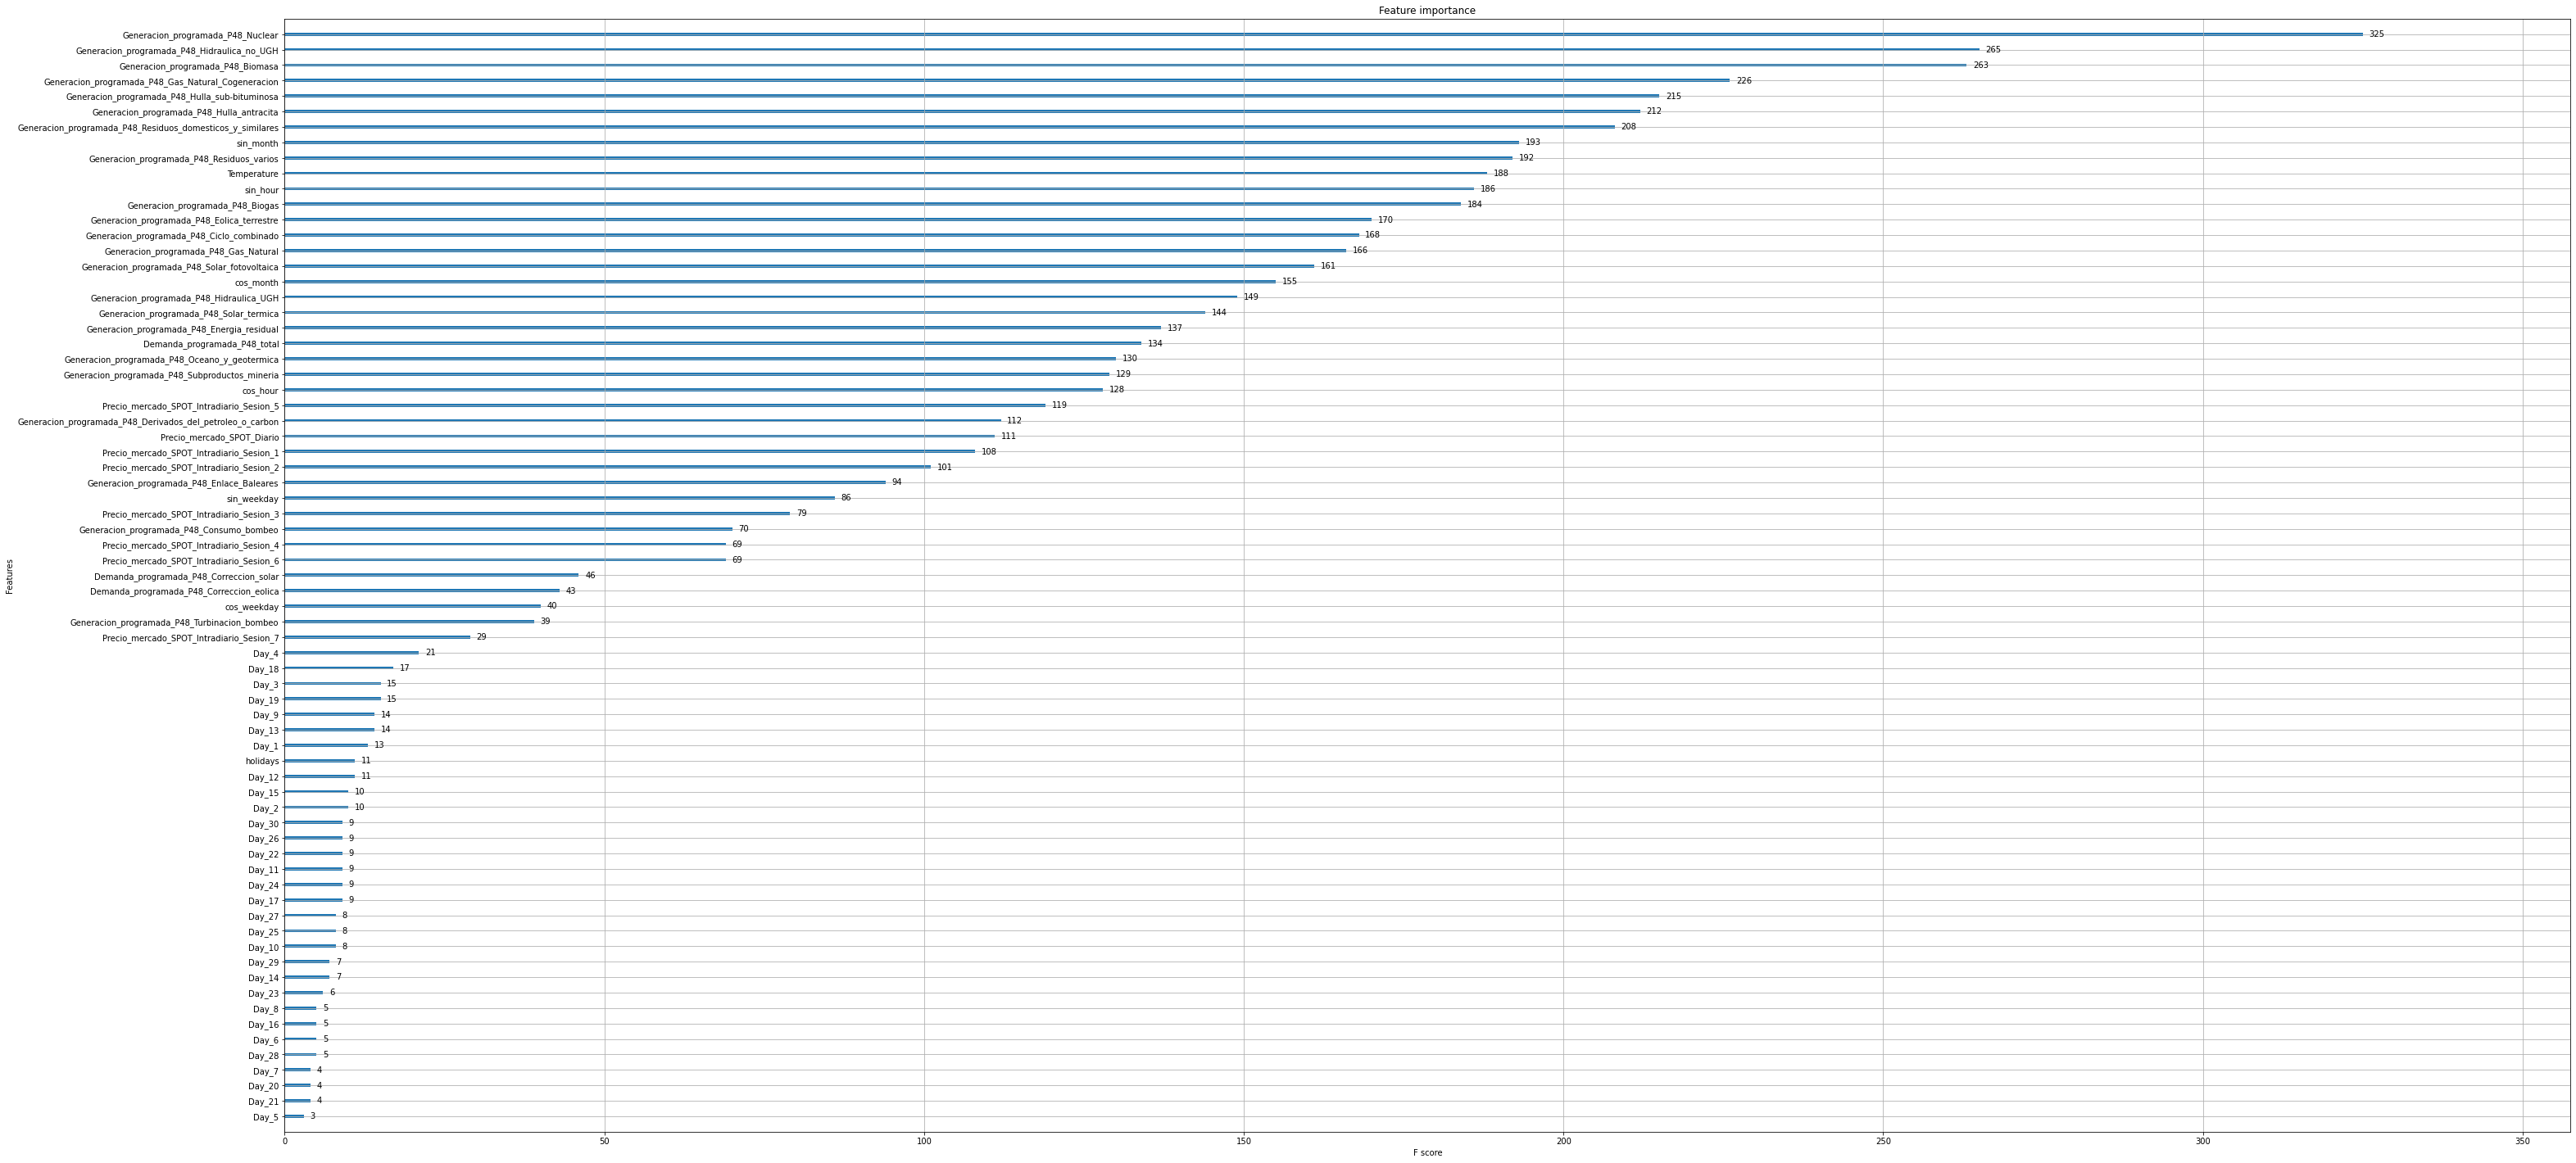

In [62]:
xgb.plot_importance(xgb_mod.best_estimator_)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

Then we calculate our prediction and check the metrics:

In [63]:
y_pred = xgb_mod.best_estimator_.predict(X_test) 
print('Se obtiene un RMSE de ',np.sqrt(mean_squared_error(y_test, y_pred)),', un R2 de ',r2_score(y_test, y_pred),' y un MAPE de',mean_absolute_percentage_error(y_test, y_pred))

Se obtiene un RMSE de  6.619850704363436 , un R2 de  0.9623111978621213  y un MAPE de 8.89589175187485


Last, we plot the results:

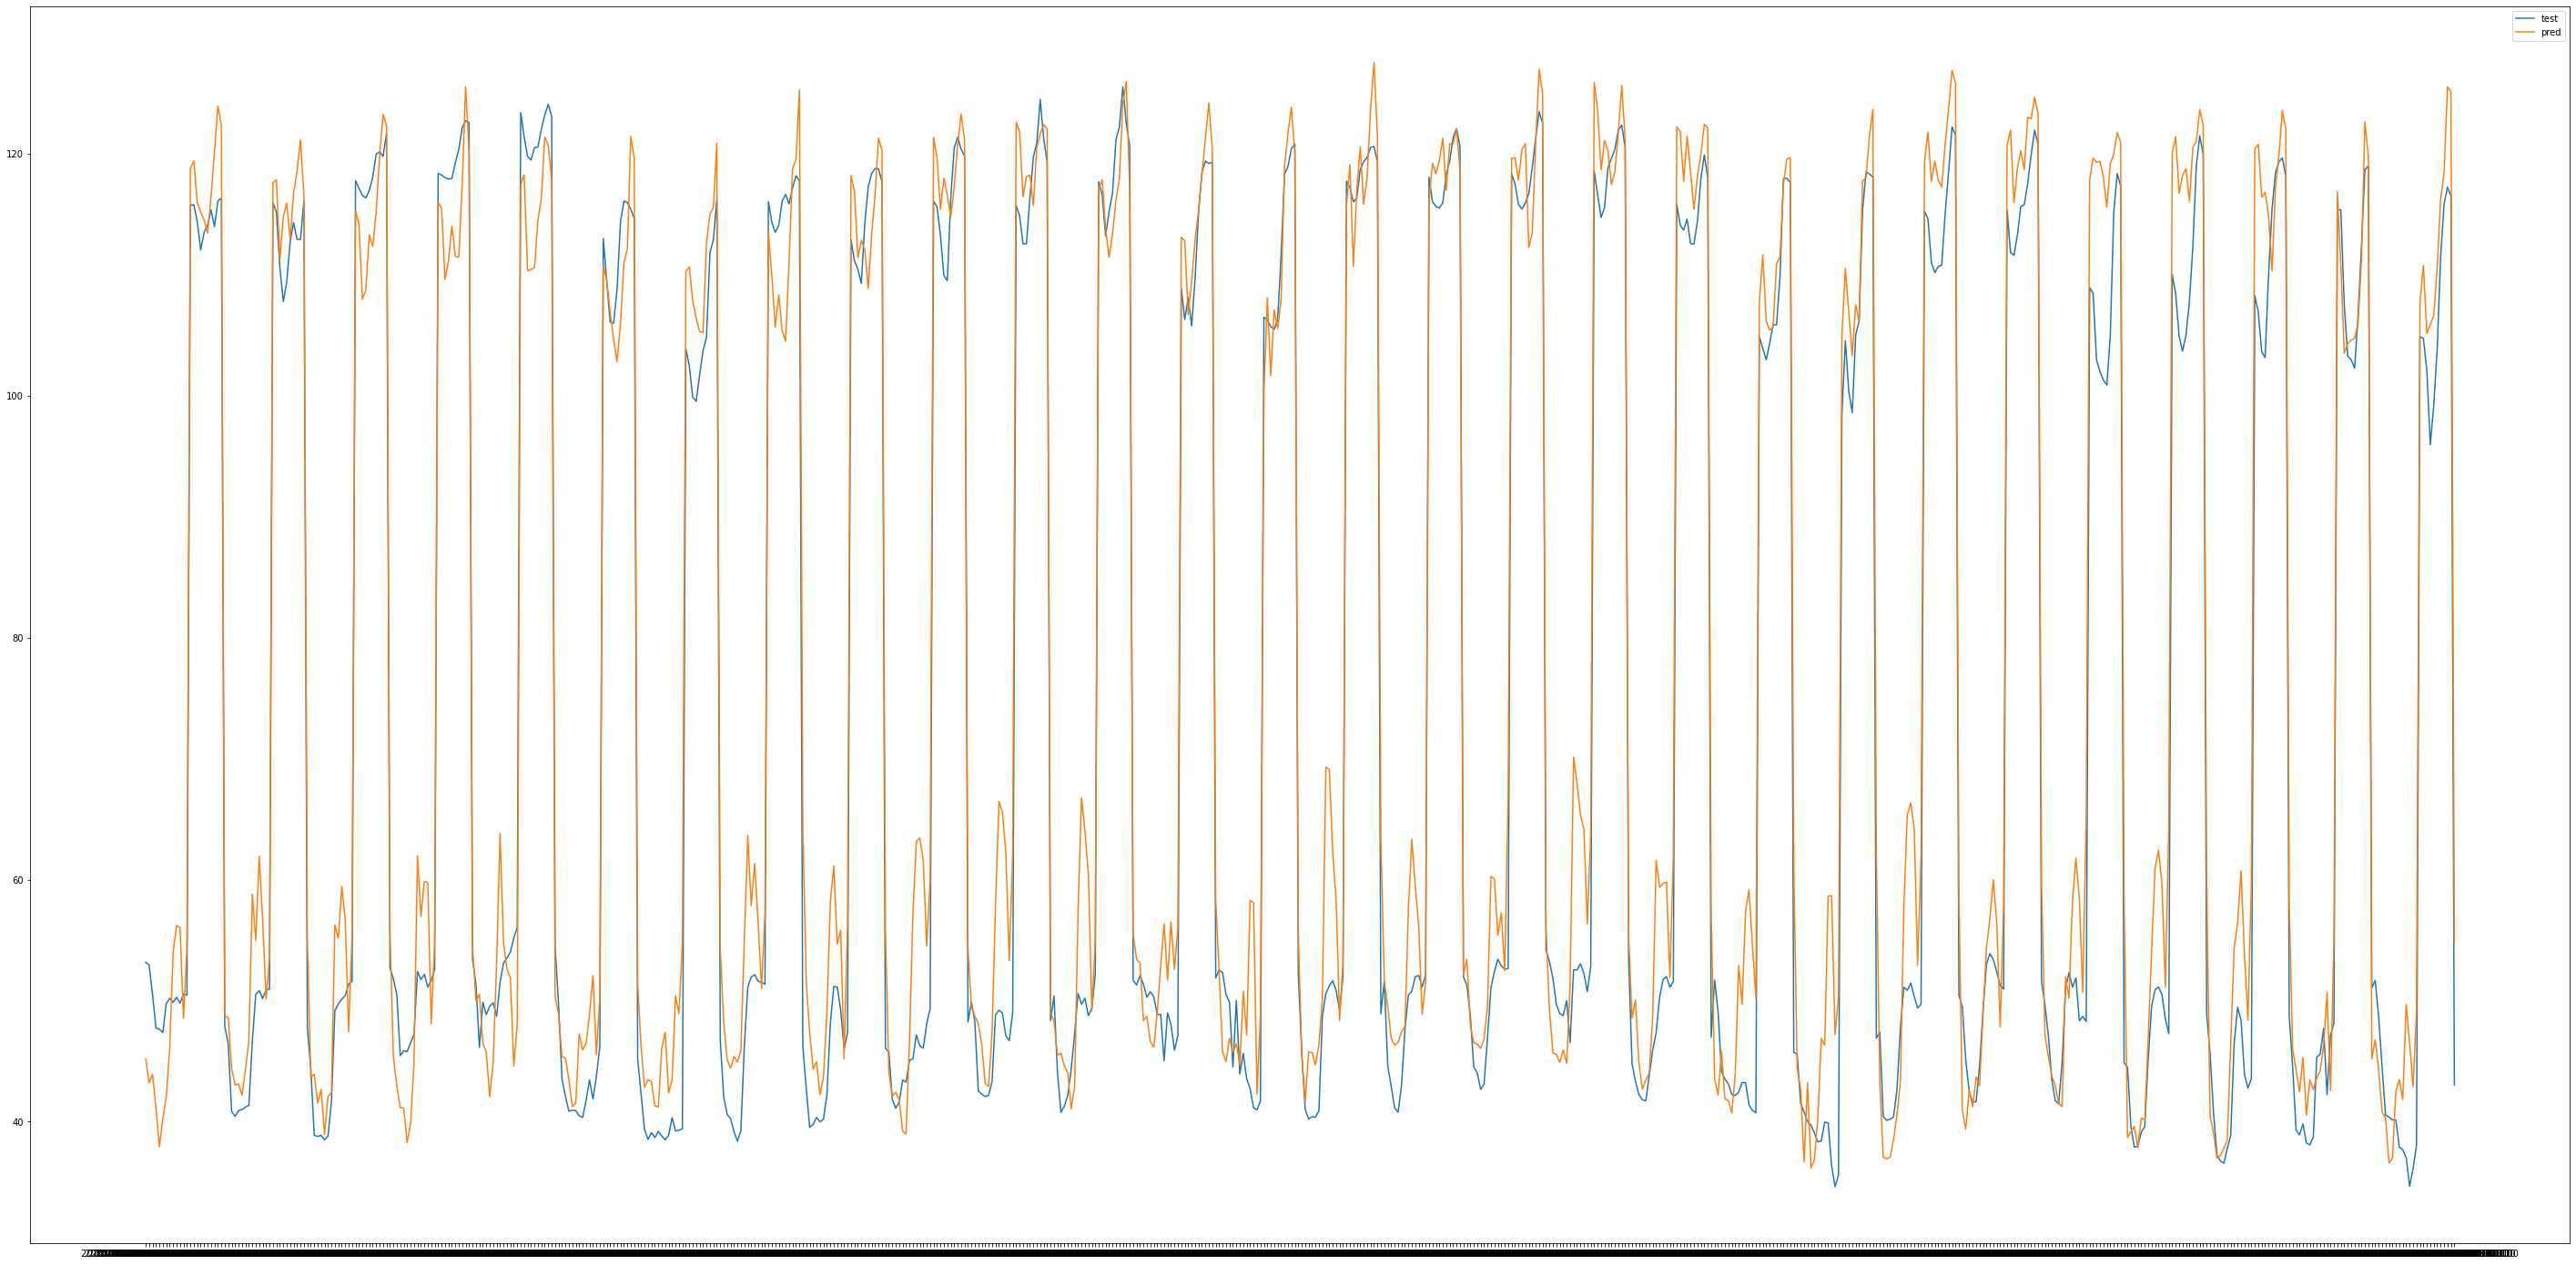

In [64]:
plt.rcParams['figure.figsize'] = [50, 25]
plt.plot(y_test, label='test')
plt.plot(y_pred, label='pred')
plt.legend()
plt.show()

In [65]:
pd.DataFrame({'y_test':y_test, 'y_pred':y_pred},index = y_test.index).to_csv('./../Visualization/Xgboost_time_series.csv')